# Learning Slope & Balance Point

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from datetime import date
sns.set()
%matplotlib inline

In [2]:
sns.set_style("whitegrid")

In [3]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing

In [4]:
import pwlf

In [5]:
plt.rcParams['figure.figsize'] = [16, 9]

In [6]:
w = pd.read_csv(r'The revised 292 F - 2018-12-31.csv',parse_dates=['Timestamp'], index_col='Timestamp')

In [7]:
w = (w - 32)/1.8
w = w.round(2)

In [8]:
e = pd.read_csv(r'afterQ295(Dec2).csv',parse_dates=['Timestamp'], index_col='Timestamp')

In [9]:
building_list = pd.read_excel('Revised startup and shutdown time all categories.xlsx', sheet_name='Office')
building_4A = building_list[building_list['Climate Zone'] == '4A']
buildings = building_4A['Building ID']

In [10]:
buildings = np.unique(buildings)

In [11]:
len(buildings)

37

In [12]:
buildings = buildings[buildings != 'MD0325ZZ']

In [13]:
building_info = pd.read_excel('extracted data of 295 buildings.xlsx',  index_col=0)

In [14]:
building_info['code']

0      AK0001ZZ
1      AK0013ZZ
2      AK0031AA
3      AL0003AC
4      AL0011ZZ
         ...   
290    IL0303ZZ
291    IL0311ZZ
292    IL2125ZZ
293    IN0031ZZ
294    KY0013ZZ
Name: code, Length: 295, dtype: object

## MD0205ZZ & MO0106ZZ, MO0134zz are deleted due to the electricity heating

In [15]:
segment = {'DC0010ZZ': 2,
           'DC0011ZZ': 2,
           'DC0021ZZ': 2,
           'DC0078ZZ': 2,
           'DC0313ZZ': 2,
           'DC0459AF': 2,
           'DC0463ZZ': 2,
           'DC0501BC': 2,
           'DC0505ZZ': 2,
           'MD0000HC': 2,
           'MD0334ZZ': 2,
           'MD0778AG': 2,
           'MO0000AF': 2,
           'MO0127ZZ': 2,
           'NC0002AE': 2,
           'PA0000AT': 2,
           'PA0144ZZ': 2,
           'VA0088ZZ': 2,
           'WV0054FP': 2,
           'WV0226ZZ': 2}

## Holiday and Problem days

'''Winter Jan, Feb
(2018, 1, 1), "New Year's Day") (Monday)
(2018, 1, 15), 'Martin Luther King Jr. Day') (Monday)
(2018, 2, 19), "Washington's Birthday") (Monday)
Spring Mar, Apr, May
(2018, 5, 28), 'Memorial Day') (Monday)
Summer Jun, Jul, Aug
(2018, 7, 4), 'Independence Day') (Wednesday)
Autumn Sep Oct Nov
(2018, 11, 12), 'Veterans Day (Observed)') (Monday)
(2018, 11, 22), 'Thanksgiving') (Thursday)'''

In [16]:
holidays = [
    date(2018, 1, 1),
    date(2018, 1, 15),
    date(2018, 2, 19),
    date(2018, 5, 28),
    date(2018, 7, 4),
    date(2018, 11, 12),
    date(2018, 11, 22),
    date(2018, 9, 3),
    date(2018, 10, 8),
    date(2018, 12, 5)
]

In [17]:
df_occ = pd.read_csv('4A 19 occupied lean detail.csv')
df_un = pd.read_csv('4A 19 unoccupied lean detail.csv')

In [25]:
df_occ[(df_occ['slope2'] > df_occ['slope2'].median()) & (df_occ['balancePoint'] < df_occ['balancePoint'].median())]

,building,balancePoint,slope1,slope2,intercept1,intercept2
1,DC0011ZZ,2.000304,-4.213855e-06,0.000011,0.001064,0.001032
3,DC0078ZZ,4.721682,1.669526e-06,0.000018,0.000654,0.000575
15,PA0000AT,11.506288,-8.323558e-07,0.000013,0.000907,0.000743
16,PA0144ZZ,10.406368,3.176777e-07,0.000011,0.000357,0.000244
18,WV0054FP,8.016216,2.670760e-06,0.000011,0.000383,0.000313


Text(0.5, 1.0, 'PA0000AT')

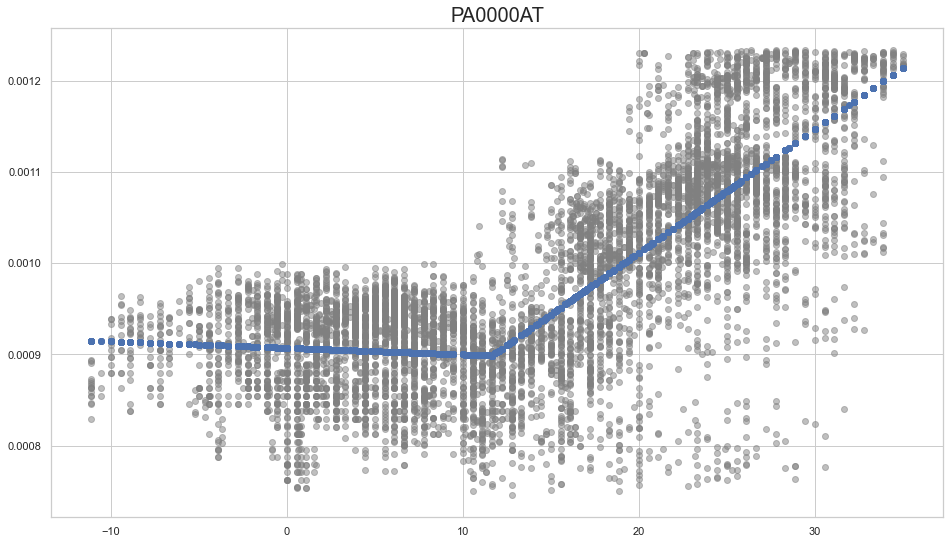

In [30]:
data = pd.DataFrame()
data['w'] = w['PA0000AT']
data['e'] = e['PA0000AT']
data = data.dropna()
data = data[~np.isin(data.index.date, holidays)]
data = data[data.index.weekday < 5].between_time('6:00', '18:00')

clustering = DBSCAN(eps=5, min_samples=8).fit(data)
res = np.unique(clustering.labels_, return_counts=True)
maj = res[0][np.argmax(res[1])]

data['e'] = data['e'] / (building_info['floor area (sf)'][building_info['code'] == 'PA0000AT'].values[0])

x, y = (data)['w'][clustering.labels_== maj], (data)['e'][clustering.labels_== maj]
f = pwlf.PiecewiseLinFit(x, y)
res = f.fit(segment['PA0000AT'])
plt.subplots()
plt.scatter((data)['w'][clustering.labels_== maj], (data)['e'][clustering.labels_== maj], c='gray', alpha=0.5)
plt.scatter(x, f.predict(x))
plt.title('PA0000AT', fontsize=20)

In [31]:
balance = f.fit_breaks[1]
a1, a2 = f.slopes
b1, b2 = f.intercepts

In [32]:
def fun1(x, balance):
    if x <= balance:
        return a1 * x + b1
    else:
        return a2 * x + b2

In [34]:
def fun2(x, balance_, a2_):
    if x <= balance_:
        return a1 * x + b1
    else:
        return a2_ * x + b1 + balance_ * (a1 - a2_)

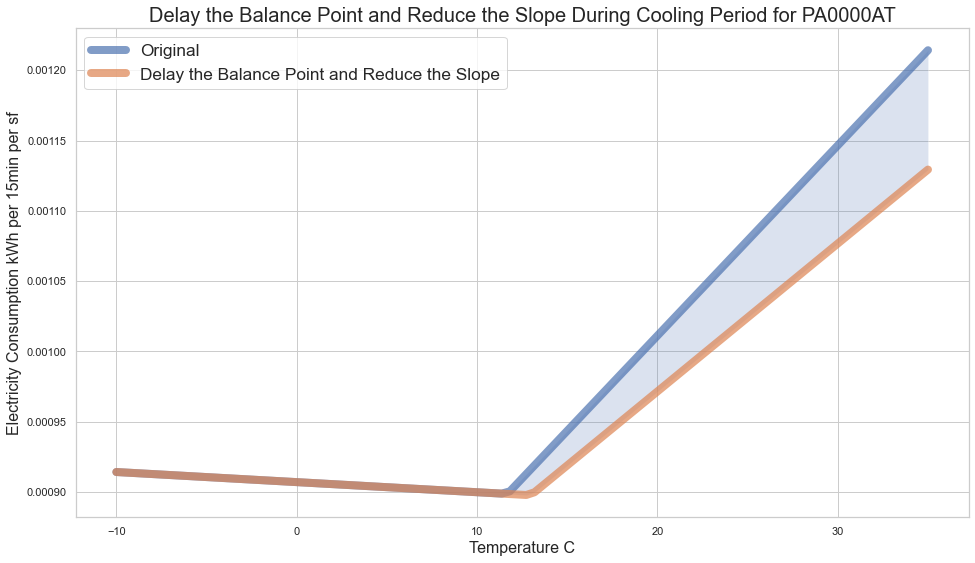

In [38]:
x = np.linspace(-10, 35, 100)
plt.plot(x, [fun1(xi, balance) for xi in x], alpha=0.7, lw=8, label='Original')
plt.plot(x, [fun2(xi, df_occ['balancePoint'].median(), df_occ['slope2'].median()) for xi in x], alpha=0.7, lw=8, label='Delay the Balance Point and Reduce the Slope')
plt.fill_between(x, [fun1(xi, balance) for xi in x], [fun2(xi, df_occ['balancePoint'].median(), df_occ['slope2'].median()) for xi in x], alpha=0.2)
plt.ylabel('Electricity Consumption kWh per 15min per sf', fontsize=16)
plt.xlabel('Temperature C', fontsize=16)
plt.title('Delay the Balance Point and Reduce the Slope During Cooling Period for PA0000AT', fontsize=20)
plt.legend(fontsize='xx-large')

In [20]:
def fun1(x, balance, a1, b1, a2, b2):
    if x <= balance:
        return a1 * x + b1
    else:
        return a2 * x + b2

In [21]:
def fun2(x, balance_, a1, b1, a2_):
    if x <= balance_:
        return a1 * x + b1
    else:
        return a2_ * x + b1 + balance_ * (a1 - a2_)

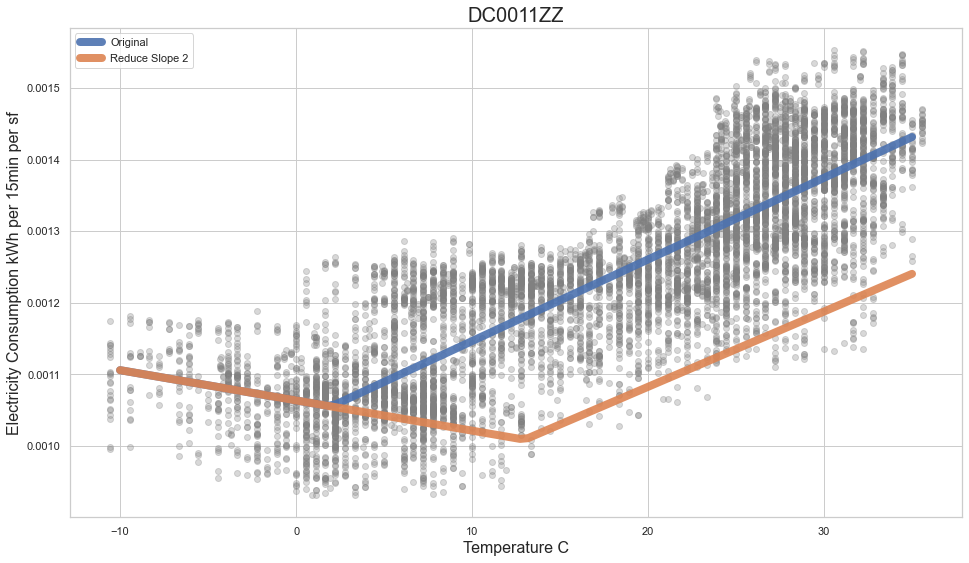

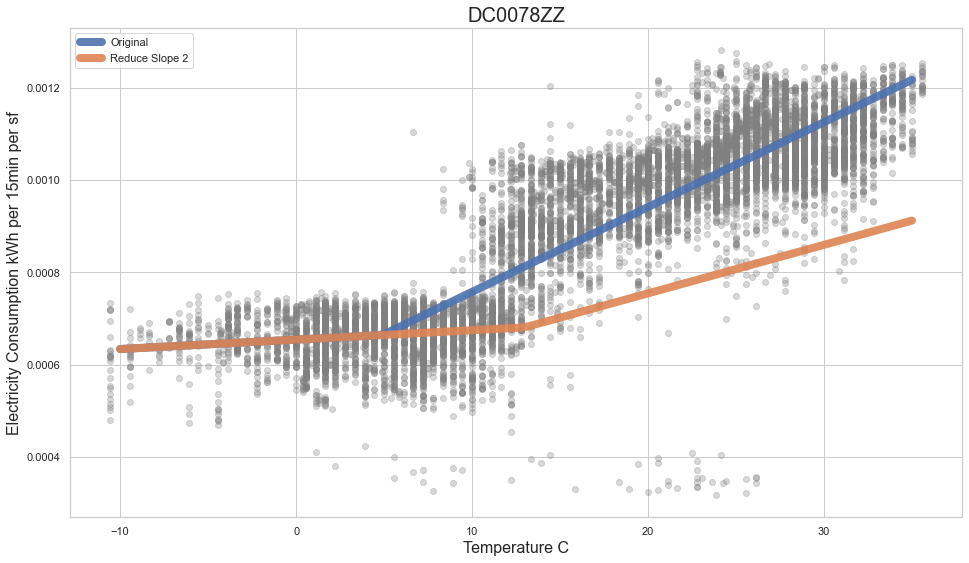

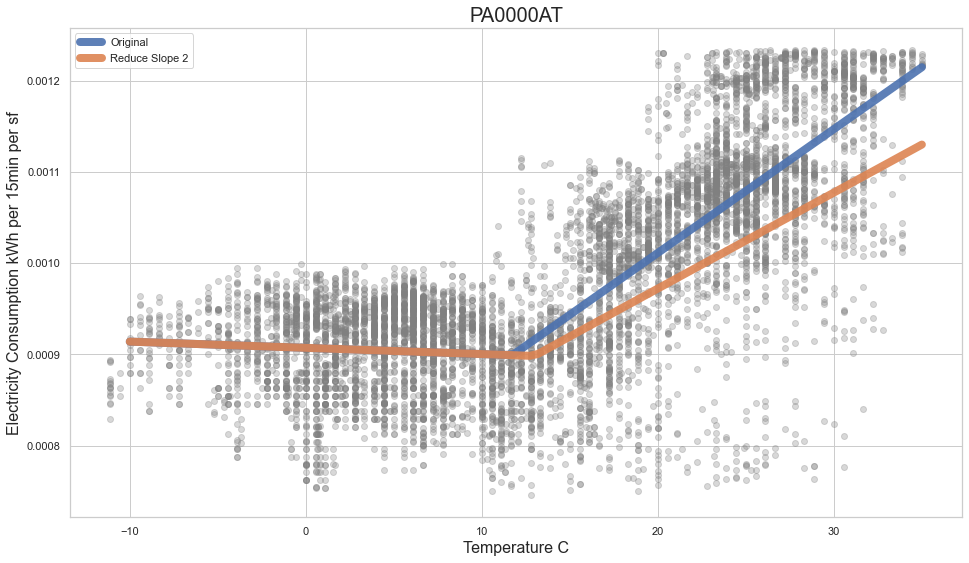

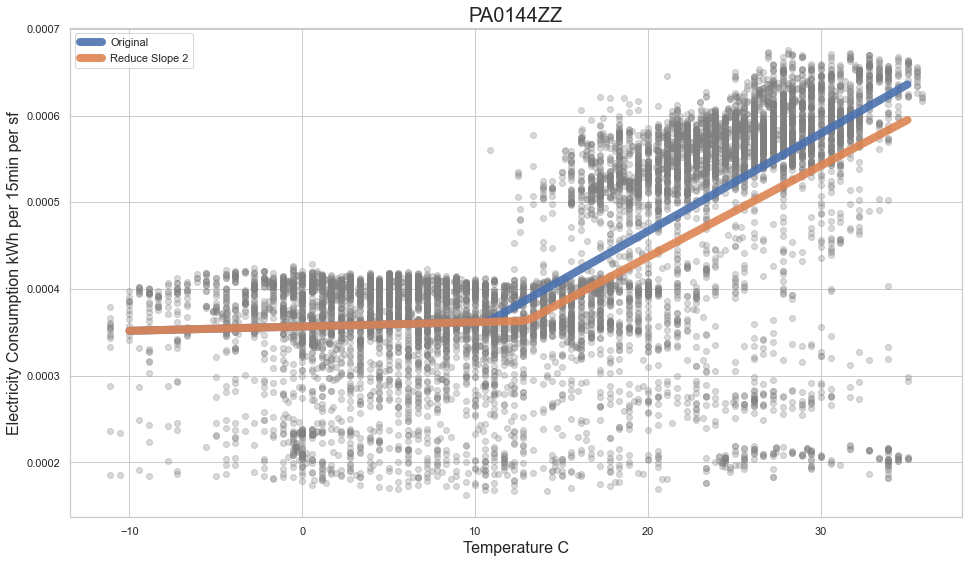

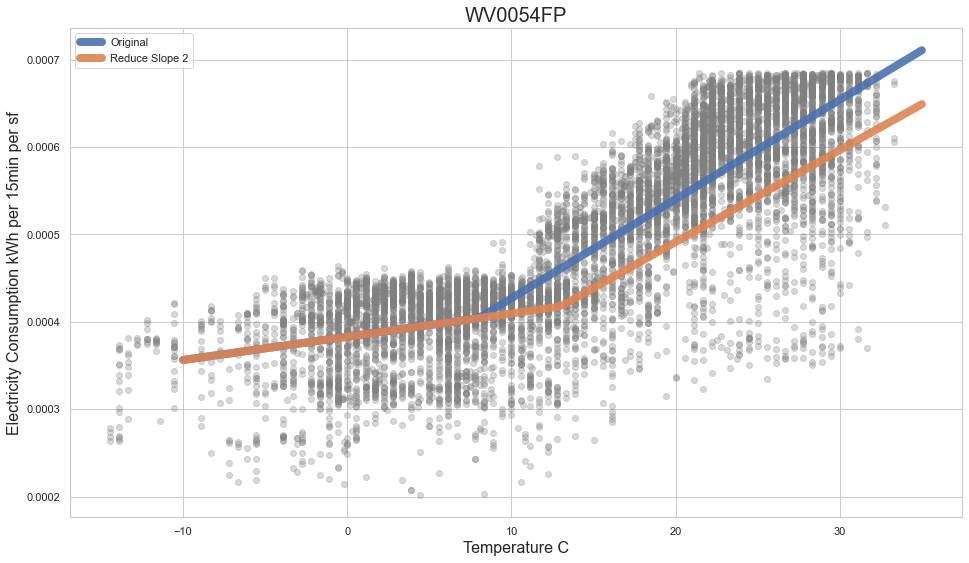

In [41]:
for i in df_occ[(df_occ['slope2'] > df_occ['slope2'].median()) & (df_occ['balancePoint'] < df_occ['balancePoint'].median())].building:
    data = pd.DataFrame()
    data['w'] = w[i]
    data['e'] = e[i]
    data = data.dropna()
    data = data[~np.isin(data.index.date, holidays)]
    data = data[data.index.weekday < 5].between_time('6:00', '18:00')
    
    clustering = DBSCAN(eps=5, min_samples=8).fit(data)
    res = np.unique(clustering.labels_, return_counts=True)
    maj = res[0][np.argmax(res[1])]
    
    data['e'] = data['e'] / (building_info['floor area (sf)'][building_info['code'] == i].values[0])
    
    x, y = (data)['w'][clustering.labels_== maj], (data)['e'][clustering.labels_== maj]
    f = pwlf.PiecewiseLinFit(x, y)
    res = f.fit(segment[i])
    plt.subplots()
    plt.scatter((data)['w'][clustering.labels_== maj], (data)['e'][clustering.labels_== maj], c='grey', alpha=0.3)
#     plt.scatter((data)['w'][clustering.labels_== maj], f.predict((data)['w'][clustering.labels_== maj]), c='blue', alpha=0.3)
    _, balancePoint, _ = f.fit_breaks
    a1, a2 = f.slopes
    b1, b2 = f.intercepts
#     plt.scatter((data)['w'][clustering.labels_== maj], [fun2(i, balancePoint, df_occ['balancePoint'].median(), a1, b1, a2, b2) for i in (data)['w'][clustering.labels_== maj]], c='red', alpha=0.3)
    plt.title(f'{i}', fontsize=20)
    x = np.linspace(-10, 35, 100)
    plt.plot(x, [fun1(i, balancePoint, a1, b1, a2, b2) for i in x], label='Original',alpha=0.9, lw=8)
    plt.plot(x, [fun2(i, df_occ['balancePoint'].median(), a1, b1, df_occ['slope2'].median()) for i in x], label='Reduce Slope 2',alpha=0.9, lw=8)
    plt.ylabel('Electricity Consumption kWh per 15min per sf', fontsize=16)
    plt.xlabel('Temperature C', fontsize=16)
    plt.legend()



In [42]:
result = pd.DataFrame()
result['building'] = df_occ[(df_occ['slope2'] > df_occ['slope2'].median()) & (df_occ['balancePoint'] < df_occ['balancePoint'].median())].building
original_e, after_e = [], []

In [43]:
for i in result['building']:
    data = pd.DataFrame()
    data['w'] = w[i]
    data['e'] = e[i]
    data = data.dropna()
    data = data[~np.isin(data.index.date, holidays)]
    data = data[data.index.weekday < 5].between_time('6:00', '18:00')
    
    clustering = DBSCAN(eps=5, min_samples=8).fit(data)
    res = np.unique(clustering.labels_, return_counts=True)
    maj = res[0][np.argmax(res[1])]
    
    data['e'] = data['e'] / (building_info['floor area (sf)'][building_info['code'] == i].values[0])
    
    x, y = (data)['w'][clustering.labels_== maj], (data)['e'][clustering.labels_== maj]
    f = pwlf.PiecewiseLinFit(x, y)
    res = f.fit(segment[i])
    
    _, balancePoint, _ = f.fit_breaks
    a1, a2 = f.slopes
    b1, b2 = f.intercepts
    original = sum([fun1(i, balancePoint, a1, b1, a2, b2) for i in (data)['w'][clustering.labels_== maj]])
    original = original * (building_info['floor area (sf)'][building_info['code'] == i].values[0])
    after = sum([fun2(i, df_occ['balancePoint'].median(), a1, b1, df_occ['slope2'].median()) for i in (data)['w'][clustering.labels_== maj]])
    after = after * (building_info['floor area (sf)'][building_info['code'] == i].values[0])
    original_e.append(original)
    after_e.append(after)

In [44]:
result['Original'] =  original_e
result['After'] = after_e

In [45]:
result['Potential Energy Saving'] = round(100 * (result['Original'] - result['After'])/result['Original'], 2)

In [46]:
result

,building,Original,After,Potential Energy Saving
1,DC0011ZZ,7107598.827,6.287738e+06,11.53
3,DC0078ZZ,531089.343,4.425326e+05,16.67
15,PA0000AT,3657204.947,3.562468e+06,2.59
16,PA0144ZZ,2748744.015,2.627257e+06,4.42
18,WV0054FP,1145047.854,1.069296e+06,6.62


In [47]:
result['Potential Energy Saving'].mean()

8.366

In [48]:
result.to_csv('Energy Saving after delay balance point & reduce the slope2 for Occupied 4A 19.csv', index=False)

Text(0.5, 0, '')

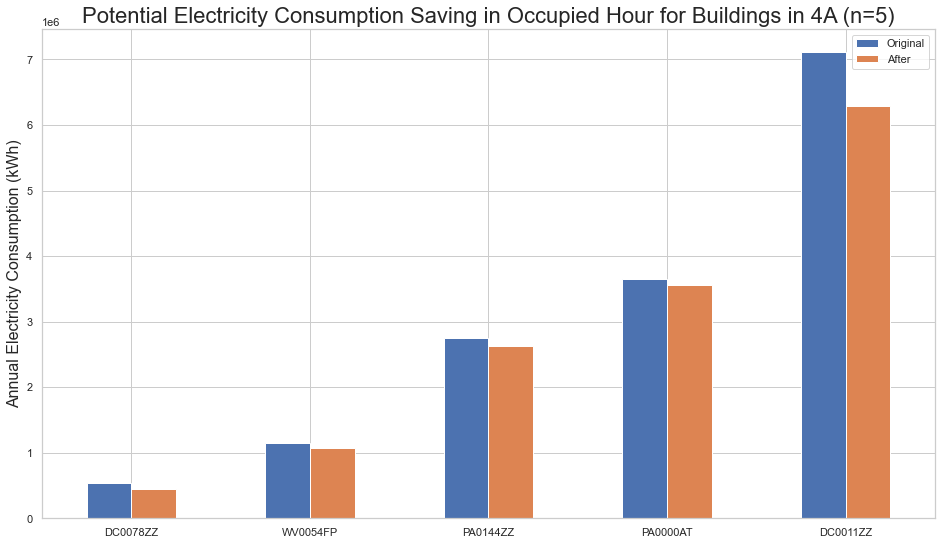

In [51]:
result.sort_values(by=['Original']).iloc[:, :-1].set_index('building').plot(kind="bar", rot=0)
plt.title('Potential Electricity Consumption Saving in Occupied Hour for Buildings in 4A (n=5)', fontsize=22)
plt.ylabel('Annual Electricity Consumption (kWh)', fontsize=16)
plt.xlabel('')

# Unoccupied Time

In [18]:
result_un = pd.DataFrame()
result_un['building'] = df_un[(df_un['slope2'] > df_un['slope2'].median()) & (df_un['balancePoint'] < df_un['balancePoint'].median())].building
original_e, after_e = [], []

In [22]:
for i in result_un['building']:
    data = pd.DataFrame()
    data['w'] = w[i]
    data['e'] = e[i]
    data = data.dropna()
    
    a = data[data.index.weekday >=5]
    b = data[data.index.weekday < 5].between_time('18:00', '6:00')
    data = pd.concat([a, b])
    
    clustering = DBSCAN(eps=5, min_samples=8).fit(data)
    res = np.unique(clustering.labels_, return_counts=True)
    maj = res[0][np.argmax(res[1])]
    
    data['e'] = data['e'] / (building_info['floor area (sf)'][building_info['code'] == i].values[0])
    
    x, y = (data)['w'][clustering.labels_== maj], (data)['e'][clustering.labels_== maj]
    f = pwlf.PiecewiseLinFit(x, y)
    res = f.fit(segment[i])
    
    _, balancePoint, _ = f.fit_breaks
    a1, a2 = f.slopes
    b1, b2 = f.intercepts
    original = sum([fun1(i, balancePoint, a1, b1, a2, b2) for i in (data)['w'][clustering.labels_== maj]])
    original = original * (building_info['floor area (sf)'][building_info['code'] == i].values[0])
    after = sum([fun2(i, df_un['balancePoint'].median(), a1, b1, df_un['slope2'].median()) for i in (data)['w'][clustering.labels_== maj]])
    after = after * (building_info['floor area (sf)'][building_info['code'] == i].values[0])
    original_e.append(original)
    after_e.append(after)

In [23]:
result_un['Original'] =  original_e
result_un['After'] = after_e
result_un['Potential Energy Saving'] = round(100 * (result_un['Original'] - result_un['After'])/result_un['Original'], 2)

In [24]:
result_un

,building,Original,After,Potential Energy Saving
10,MD0334ZZ,8472744.396,7.431306e+06,12.29
18,WV0054FP,1422333.602,1.259486e+06,11.45


In [25]:
result_un['Potential Energy Saving'].mean()

11.87

In [62]:
result_un.to_csv('Energy Saving after delay balance point and reduce the slope2 for Unoccupied 4A 2.csv', index=False)

Text(0.5, 0, '')

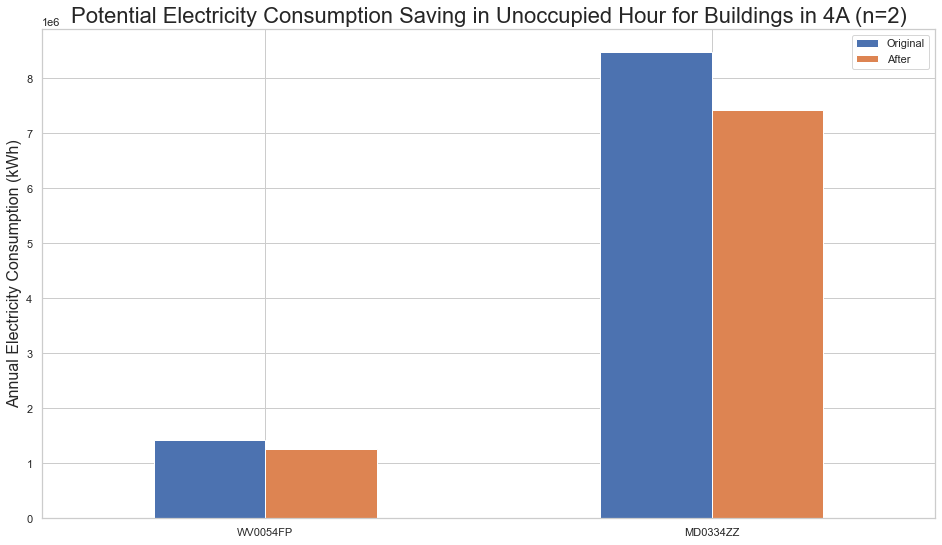

In [27]:
result_un.sort_values(by=['Original']).iloc[:, :-1].set_index('building').plot(kind="bar", rot=0)
plt.title('Potential Electricity Consumption Saving in Unoccupied Hour for Buildings in 4A (n=2)', fontsize=22)
plt.ylabel('Annual Electricity Consumption (kWh)', fontsize=16)
plt.xlabel('')